In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import constants
import itertools
import skrf as rf
import pandas as pd
from tabulate import tabulate
from matplotlib.lines import Line2D


%config InlineBackend.figure_format = 'svg'
plt.rcParams['lines.linewidth'] = 0.8

## Constants

In [2]:
epsilon_0 = constants.epsilon_0

fstart = 1
fstop = 10
fpoints = 500
f = np.logspace(fstart, fstop, fpoints)

l = 1e-8

In [3]:
S_storage1 = {}
S_storage2 = {}
S_storage3 = {}
S_storage4 = {}

## Prameters Setup

In [4]:
def Z_eff_2_L_C(Z0o, Z0e, eps_o, eps_e, L, T):
    c = constants.speed_of_light

    Lo = (Z0o/c)*np.sqrt(eps_o)
    Co_no_shunt = np.sqrt(eps_o)/(c*Z0o)

    Le = (Z0e/c)*np.sqrt(eps_e)
    Ce_no_shunt = np.sqrt(eps_e)/(c*Z0e)
    
    Ca = Ce_no_shunt
    Cm = (Co_no_shunt+Ce_no_shunt)/2

    Cst = (constants.epsilon_0*T)/(10e-5) # shunt capacitance

    return Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Cm, Cst

def L_C_2_Z_eff(Lo, Co_no_shunt, Le, Ce_no_shunt):
    c = constants.speed_of_light
    
    eps_o = (Co_no_shunt * Lo) * (c ** 2)
    Z0o = np.sqrt(Lo/Co_no_shunt)
    
    eps_e = (Ce_no_shunt * Le) * (c ** 2)
    Z0e = np.sqrt(Le/Ce_no_shunt)
        
    return Z0o, Z0e, eps_o/constants.epsilon_0, eps_e/constants.epsilon_0


In [5]:
Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Cm, Cst = Z_eff_2_L_C(50, 48, 5, 5, l, 0.035e-6)

# Create a list of tuples containing variable names and their values
variables = [
    ("Lo", Lo),
    ("Co_no_shunt", Co_no_shunt),
    ("Le", Le),
    ("Ce_no_shunt", Ce_no_shunt),
    ("Ca", Ca),
    ("Cm", Cm),
    ("Cst", Cst), 
    ("Zo", np.sqrt(Lo/Co_no_shunt)),
    ("Ze", np.sqrt(Le/Ce_no_shunt)),
    ("esp_o_off", Lo*Co_no_shunt*constants.speed_of_light**2),
    ("eps_e_off", Le*Ce_no_shunt*constants.speed_of_light**2),
    ("eps_o_on", Lo*(Co_no_shunt + Cst)*constants.speed_of_light**2),
    ("eps_e_on", Le*Ce_no_shunt*constants.speed_of_light**2),

]

# Print the variables in a table
print(tabulate(variables, headers=["Variable", "Value"]))

Variable            Value
-----------  ------------
Lo            3.72936e-07
Co_no_shunt   1.49174e-10
Le            3.58019e-07
Ce_no_shunt   1.5539e-10
Ca            1.5539e-10
Cm            1.52282e-10
Cst           3.09897e-15
Zo           50
Ze           48
esp_o_off     5
eps_e_off     5
eps_o_on      5.0001
eps_e_on      5


## Matrix Algebra

In [6]:
def invert_mat(A):
    inv_A = np.zeros((len(A[0, :, 0]), len(A[:, 0, 0]), len(A[0, 0, :])), dtype=np.complex128)
    for i in range(len(A[0, 0])):
        inv_A[:, :, i] = np.linalg.inv(A[:, :, i])

    return inv_A

def multiply_mat(A, B):
    C = np.zeros((len(A[0, :, 0]), len(A[:, 0, 0]), len(A[0, 0, :])), dtype=np.complex128)
    for i in range(len(A[0, 0, :])):
        C[:, :, i] = A[:, :, i] @ B[:, :, i]

    return C

## Mode Extraction

In [7]:
def odd_mode_params(f, Lo, Cm, Ca, Gm, Ga, R):
    w = 2*np.pi*f
    Co = 2*Cm - Ca
    Go = 2*Gm + Ga
    Lo = Lo
    Ro = R
    #gamma_o = 1e-5 + 1j*(2*np.pi*w*np.sqrt(Lo*Co))
    gamma_o = np.sqrt( (1j*w*Lo + Ro)*(1j*w*(Co) + Go) )
    Z0o = np.sqrt((Ro+1j*w*Lo)/(Go + 1j*w*Co))


    f0_o = 1/(2*np.pi*np.sqrt(Lo*Co)) # frequency at which the coupled lines are a quarter-wavelength long electrically when excited in the odd mode
    f0_o = 1/(2*np.pi*np.sqrt((1j*w*Lo + Ro)*(1j*w*(Co) + Go)))
    theta_o = (np.pi/2)*(f/f0_o)

    return Lo, Co, Go, Ro, gamma_o, Z0o, theta_o

def even_mode_params(f, Le, Cm, Ca, Gm, Ga, R):
    w = 2*np.pi*f
    Ce = Ca
    Ge = Ga
    Le = Le
    Re = R
    #gamma_e = 1e-4 + 1j*(2*np.pi*w*np.sqrt(Le*Ce))
    gamma_e = np.sqrt( (1j*w*Le + Re)*(1j*w*(Ce) + Ge) )
    Z0e = np.sqrt((Re+1j*w*Le)/(Ge + 1j*w*Ce))

    f0_e = 1/(2*np.pi*np.sqrt(Le*Ce)) #frequency at which the coupled lines are a quarter-wavelength long electrically when excited in the even mode,
    f0_e = 1/(2*np.pi*np.sqrt((1j*w*Le + Re)*(1j*w*(Ce) + Ge)))
    theta_e = (np.pi/2)*(f/f0_e)

    return Le, Ce, Ge, Re, gamma_e, Z0e, theta_e

## Z Matrix

In [8]:
def create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o):

    Z11 = -(1j/2) * (Z0e*cot_theta_e + Z0o*cot_theta_o)
    Z12 = -(1j/2) * (Z0e*cot_theta_e - Z0o*cot_theta_o)
    Z13 = -(1j/2) * (Z0e*csc_theta_e - Z0o*csc_theta_o)
    Z14 = -(1j/2) * (Z0e*csc_theta_e + Z0o*csc_theta_o)


    Z = np.zeros((4, 4, len(Z11)), dtype=np.complex128)

    Z[0][0][:] = Z11
    Z[1][1][:] = Z[0][0][:]
    Z[2][2][:] = Z[0][0][:]
    Z[3][3][:] = Z[0][0][:]

    Z[0][1][:] = Z12
    Z[1][0][:] = Z[0][1][:]
    Z[2][3][:] = Z[0][1][:]
    Z[3][2][:] = Z[0][1][:]

    Z[0][2][:] = Z13
    Z[2][0][:] = Z[0][2][:]
    Z[1][3][:] = Z[0][2][:]
    Z[3][1][:] = Z[0][2][:]

    Z[0][3][:] = Z14
    Z[3][0][:] = Z[0][3][:]
    Z[1][2][:] = Z[0][3][:]
    Z[2][1][:] = Z[0][3][:]

    return Z

## Z $\to$ S and S $\to$ Z

In [9]:
def create_F(Z01, Z02, Z03, Z04):
    F = np.zeros((4, 4, len(Z01)), dtype=np.complex128)
    F[0][0][:] = 1/(2*np.sqrt(Z01))
    F[1][1][:] = 1/(2*np.sqrt(Z02))
    F[2][2][:] = 1/(2*np.sqrt(Z03))
    F[3][3][:] = 1/(2*np.sqrt(Z04))
    return F

def create_G(Z01, Z02, Z03, Z04):
    G = np.zeros((4, 4, len(Z01)), dtype=np.complex128)
    G[0][0][:] = Z01
    G[1][1][:] = Z02
    G[2][2][:] = Z03
    G[3][3][:] = Z04
    return G

def create_reduced_F(f):
    F = np.zeros((2, 2, len(f)), dtype=np.complex128)
    F[0][0][:] = 1/(2*np.sqrt(50))
    F[1][1][:] = 1/(2*np.sqrt(50))

    return F

def create_reduced_G(f):
    G = np.zeros((2, 2, len(f)), dtype=np.complex128)
    G[0][0][:] = 50
    G[1][1][:] = 50

    return G

def z2s(Z, F, G):
    
    # Calculate Z - G* and Z + G
    Z_minus_G_star = Z - np.conj(G)
    Z_plus_G = Z + G
    
    # Calculate the inverse of Z + G
    Z_plus_G_inv = invert_mat(Z_plus_G)
    
    # Calculate F^(-1)
    F_inv = invert_mat(F)
    
    # Calculate S = F(Z - G*)(Z + G)^(-1)F^(-1)
    S = multiply_mat(multiply_mat(F, Z_minus_G_star), multiply_mat(Z_plus_G_inv, F_inv))
    
    return S

def s2z(S, F, G):
    # Calculate the identity matrix I of the same shape as S
    I = np.zeros(S.shape, dtype=np.complex128)
    for i in range(S.shape[2]):
        I[:, :, i] = np.eye(4, dtype=np.complex128)
    
    # Calculate (I - S)^(-1)
    I_minus_S_inv = invert_mat(I - S)
    
    # Calculate SG + G*
    SG_plus_G_star = multiply_mat(S, G) + np.conj(G)
    
    # Calculate F^(-1)
    F_inv = invert_mat(F)
    
    # Calculate Z = F^(-1)(I - S)^(-1)(SG + G*)F
    Z = multiply_mat(multiply_mat(F_inv, I_minus_S_inv), multiply_mat(SG_plus_G_star, F))
    
    return Z

## ABCD Matrices

In [10]:
def s2abcd(S, Z0):
    ABCD = np.zeros((2, 2, len(f)), dtype=np.complex128)
    S11 = S[0, 0, :]
    S12 = S[0, 1, :]
    S21 = S[1, 0, :]
    S22 = S[1, 1, :]
    ABCD[0, 0, : ] = ( (1+S11)*(1-S22) + S12*S21 )/( 2*S21 )
    ABCD[0, 1, :] = Z0* ( (1+S11)*(1+S22) - S12*S21 )/( 2*S21 )
    ABCD[1, 0, :] = (1/Z0) * ( (1+S11)*(1+S22) - S12*S21 )/( 2*S21 )
    ABCD[1, 1, :] = ( (1-S11)*(1+S22) + S12*S21 )/( 2*S21 )

    return ABCD

def plot_ABCD(f, A, B, C, D):
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    ax.flat[0].semilogx(f, np.abs(A))
    ax.flat[0].set_xlabel("f")
    ax.flat[0].set_ylabel("$20 \cdot \log_{10}(A)$")
    ax.flat[0].grid(True)  # Add grid lines

    ax.flat[1].semilogx(f, np.abs(B))
    ax.flat[1].set_xlabel("f")
    ax.flat[1].set_ylabel("$20 \cdot \log_{10}(B)$")
    ax.flat[1].grid(True)  # Add grid lines

    ax.flat[2].semilogx(f, np.abs(C))
    ax.flat[2].set_xlabel("f")
    ax.flat[2].set_ylabel("$20 \cdot \log_{10}(C)$")
    ax.flat[2].grid(True)  # Add grid lines

    ax.flat[3].semilogx(f, np.abs(D))
    ax.flat[3].set_xlabel("f")
    ax.flat[3].set_ylabel("$20 \cdot \log_{10}(D)$")
    ax.flat[3].grid(True)  # Add grid lines

    plt.show()

## $\epsilon_{eff}$

In [11]:
def plot_e_eff(gamma, f):
    eps = ( np.imag(gamma)*constants.speed_of_light/(2*np.pi*f) )**2
    plt.figure()
    plt.semilogx(f, eps)
    plt.show()

## Create S Matrix for 4 port Switch on-off

In [12]:
def create_S_off(f, Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Gm, Ga, R):
    Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, Lo, Co_no_shunt, Ca, Gm, Ga, R)
    Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, Le, Ce_no_shunt, Ca, Gm, Ga, R)

    cot_theta_o = 1/np.tan(theta_o)
    cot_theta_e = 1/np.tan(theta_e)

    csc_theta_o = 1/np.sin(theta_o)
    csc_theta_e = 1/np.sin(theta_e)

    Z = create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o)

    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    return z2s(Z, F, G) # convert to S parameters for cascading

def create_S_on(f, Lo, Co_plus_shunt, Le, Ce_plus_shunt, Ca, Gm, Ga, R):
    Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, Lo, Co_plus_shunt, Ca, Gm, Ga, R)
    Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, Le, Ce_plus_shunt, Ca, Gm, Ga, R)

    cot_theta_o = 1/np.tan(theta_o)
    cot_theta_e = 1/np.tan(theta_e)

    csc_theta_o = 1/np.sin(theta_o)
    csc_theta_e = 1/np.sin(theta_e)

    Z = create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o)

    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    return z2s(Z, F, G) # convert to S parameters for cascading

## 2-Port Convertors

In [13]:
# V2 = 0 and I3 = 0 - reduces the matrix to that of a 2 port system

# Configuration 1: Ports 1 and 2 Retained (Ports 3 and 4 Eliminated)
def reduce_config1(Z):
    return Z[np.ix_([0, 1], [0, 1])]

# Configuration 2: Ports 1 and 3 Retained (Ports 2 and 4 Eliminated)
def reduce_config2(Z):
    return Z[np.ix_([0, 2], [0, 2])]

# Configuration 3: Ports 1 and 4 Retained (Ports 2 and 3 Eliminated)
def reduce_config3(Z):
    return Z[np.ix_([0, 3], [0, 3])]

# Configuration 4: Ports 2 and 3 Retained (Ports 1 and 4 Eliminated)
def reduce_config4(Z):
    return Z[np.ix_([1, 2], [1, 2])]



def convert_final_S_to_2_port_S_config_1(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_lpf = reduce_config1(Z)
    return z2s(Z_lpf, create_reduced_F(f), create_reduced_G(f))

def convert_final_S_to_2_port_S_config_2(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_bpf = reduce_config1(Z)
    return z2s(Z_bpf, create_reduced_F(f), create_reduced_G(f))

def convert_final_S_to_2_port_S_config_3(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_bpf = reduce_config3(Z)
    return z2s(Z_bpf, create_reduced_F(f), create_reduced_G(f))


def convert_final_S_to_2_port_S_config_4(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_bpf = reduce_config4(Z)
    return z2s(Z_bpf, create_reduced_F(f), create_reduced_G(f))

## Trying all Combinations

In [14]:
def find_final_S_params_1(S_on, S_off, input):
    for i in range(len(input)):
        if (i == 0 and input[i] == 0):
            S = S_off
        if (i == 0 and input[i] == 1):
            S = S_on
        else:
            if (input[i] == 0):
                S = multiply_mat(S, S_off)
            else:
                S = multiply_mat(S, S_on)
    return convert_final_S_to_2_port_S_config_1(S)

def find_final_S_params_2(S_on, S_off, input):
    for i in range(len(input)):
        if (i == 0 and input[i] == 0):
            S = S_off
        if (i == 0 and input[i] == 1):
            S = S_on
        else:
            if (input[i] == 0):
                S = multiply_mat(S, S_off)
            else:
                S = multiply_mat(S, S_on)
    return convert_final_S_to_2_port_S_config_2(S)

def find_final_S_params_3(S_on, S_off, input):
    for i in range(len(input)):
        if (i == 0 and input[i] == 0):
            S = S_off
        if (i == 0 and input[i] == 1):
            S = S_on
        else:
            if (input[i] == 0):
                S = multiply_mat(S, S_off)
            else:
                S = multiply_mat(S, S_on)
    return convert_final_S_to_2_port_S_config_3(S)

def find_final_S_params_4(S_on, S_off, input):
    for i in range(len(input)):
        if (i == 0 and input[i] == 0):
            S = S_off
        if (i == 0 and input[i] == 1):
            S = S_on
        else:
            if (input[i] == 0):
                S = multiply_mat(S, S_off)
            else:
                S = multiply_mat(S, S_on)
    return convert_final_S_to_2_port_S_config_4(S)

def all_possible_S_params(S_on, S_off, input_matrix, S_storage, config):
    if (config == 1):
        for i in range(len(input_matrix[:, 0])):
            S_storage[i] = find_final_S_params_1(S_on, S_off, input_matrix[i, :])
    if (config == 2):
        for i in range(len(input_matrix[:, 0])):
            S_storage[i] = find_final_S_params_2(S_on, S_off, input_matrix[i, :])
    if (config == 3):
        for i in range(len(input_matrix[:, 0])):
            S_storage[i] = find_final_S_params_3(S_on, S_off, input_matrix[i, :])
    if (config == 4):
        for i in range(len(input_matrix[:, 0])):
            S_storage[i] = find_final_S_params_4(S_on, S_off, input_matrix[i, :])

## Plot

In [15]:
def plot_S_params(f, S, title):
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    for i in range(4):
        ax.flat[i].semilogx(f, 20*np.log10(np.abs(S[int(i/2), i%2, :])))
        ax.flat[i].grid(True)  # Add grid lines
    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    plt.show()

def plot_full_Z_params(f, Z, title):
    gridSize = int(np.ceil(np.sqrt(16)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(15, 15))
    for i in range(16):
        row = int(i / 4)
        col = i % 4

        # Create a new y-axis on the right side of the current axes
        ax2 = ax.flat[i].twinx()

        # Plot the real part on the left y-axis and imaginary part on the right y-axis
        ax.flat[i].semilogx(f, np.real(Z[row, col, :]), label='Real')
        ax2.semilogx(f, np.imag(Z[row, col, :]), label='Imaginary', color='red')

        # Set labels and legends
        #ax.flat[i].set_ylabel('Real', color='blue')
        #ax2.set_ylabel('Imaginary', color='red')
        ax.flat[i].grid(True)
        
        # Add legends
        lines_1, labels_1 = ax.flat[i].get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        lines = lines_1 + lines_2
        labels = labels_1 + labels_2
        ax.flat[i].legend(lines, labels)

    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    plt.show()


def plot_full_S_params(f, S, title):
    gridSize = int(np.ceil(np.sqrt(16)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(15, 15))
    for i in range(16):
        ax.flat[i].semilogx(f, 20*np.log10(np.abs(S[int(i/4), i%4, :])))
        ax.flat[i].grid(True)  # Add grid lines
    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    plt.show()

'''def plot_all_possible_S_params(f, S_storage, title, n):
    N = len(S_storage)
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 8))

    # Create a list of legend entries
    legend_entries = []
    for j in range(0, N, int(N/n)):
        legend_entries.append(f"index={format(j, f'0{8}b')}")

    # Add a legend to each subplot
    for i in range(4):
        for j in range(0, N, int(N/n)):
            line, = ax.flat[i].semilogx(f, 20*np.log10(np.abs(S_storage[j][int(i/2), i%2, :])))
        ax.flat[i].grid(True)  # Add grid lines

    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    fig_S_params.legend(legend_entries)
    plt.show()'''


def plot_tan_csc(theta_o, theta_e):
    cot_theta_o = 1/np.tan(theta_o)
    cot_theta_e = 1/np.tan(theta_e)
    csc_theta_o = 1/np.sin(theta_o)
    csc_theta_e = 1/np.sin(theta_e)
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    ax.flat[0].semilogx(theta_o, cot_theta_o)
    ax.flat[0].grid(True)  # Add grid lines
    ax.flat[1].semilogx(theta_e, cot_theta_e)
    ax.flat[1].grid(True)  # Add grid lines
    ax.flat[2].semilogx(theta_o, csc_theta_o)
    ax.flat[2].grid(True)  # Add grid lines
    ax.flat[3].semilogx(theta_e, cot_theta_e)
    ax.flat[3].grid(True)  # Add grid lines
    plt.show()


def moving_average(data, window_size):
    """Calculate the moving average of a 1D array."""
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size



def plot_all_possible_S_params(f, S_storage, title, n, smooth_window=5):
    N = len(S_storage)
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 8))

    # Create a list of legend entries
    legend_entries = []
    for j in range(0, N, int(N/n)):
        legend_entries.append(f"index={format(j, f'0{8}b')}")

    # Add a legend to each subplot
    for i in range(4):
        for j in range(0, N, int(N/n)):
            # Smooth the S-parameter data
            smoothed_S = moving_average(20*np.log10(np.abs(S_storage[j][int(i/2), i%2, :])), smooth_window)
            line, = ax.flat[i].semilogx(f[:len(smoothed_S)], smoothed_S)
        ax.flat[i].grid(True)  # Add grid lines

    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    fig_S_params.legend(legend_entries)
    plt.show()

## Input Impedance

In [16]:
def find_Zin(ZL, Zc, gamma, l):
    return Zc * ( (ZL + 1j*Zc*np.tan(gamma*l))/(Zc + 1j*ZL*np.tan(gamma*l)) )

def create_possible_impedances_matrix_odd(f, num_of_sections, Lo, Co, gamma_o, l):
    imp = np.zeros((f, num_of_sections), dtype=complex)
    Zin = 50*np.ones(len(f))
    for i in range(num_of_sections):
        Zin = find_Zin(Zin, np.sqrt(Lo/Co), gamma_o, l)
        imp[i] = Zin
    return imp


def plot_off_even_Z_in(f, Z0o, Z0e, gamma_o, gamma_e, l):

    Zin_o = find_Zin(50*np.ones(len(f)), Z0o, gamma_o, l)
    Zin_e = find_Zin(50*np.ones(len(f)), Z0e, gamma_e, l)
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    
    # Plot real and imaginary parts of Zin_e
    ax1.semilogx(f, np.real(Zin_e), label='Real(Zin_e)')
    ax1.semilogx(f, np.imag(Zin_e), label='Imag(Zin_e)')
    ax1.set_xlabel('Frequency (f)')
    ax1.set_ylabel('Impedance')
    ax1.set_title('Zin_e')
    ax1.legend()

    # Plot real and imaginary parts of Zin_o
    ax2.semilogx(f, np.real(Zin_o), label='Real(Zin_o)')
    ax2.semilogx(f, np.imag(Zin_o), label='Imag(Zin_o)')
    ax2.set_xlabel('Frequency (f)')
    ax2.set_ylabel('Impedance')
    ax2.set_title('Zin_o')
    ax2.legend()
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()

## Checking cut-offs

In [17]:
def find_cutoff_frequency(frequencies, s11_values, threshold=0.708):
    """
    Find the first cutoff frequency in the S11 vs. frequency plot.

    Parameters:
    - frequencies: An array of frequency values.
    - s11_values: An array of S11 values corresponding to the frequencies.
    - threshold: The threshold value to determine the cutoff point (default is 0.1).

    Returns:
    - cutoff_frequency: The first cutoff frequency found.
    """
    # Find the index where S11 first drops below the threshold
    below_threshold_indices = np.where(s11_values < threshold)[0]

    if len(below_threshold_indices) > 0:
        # Get the index of the first occurrence
        cutoff_index = below_threshold_indices[0]
        cutoff_frequency = frequencies[cutoff_index]
        return cutoff_frequency
    else:
        # If no cutoff point is found, return None
        return None
    
import numpy as np

'''def find_cutoff_frequencies(frequencies, s11_values, type, threshold=-3.0):
    """
    Find the first and second cutoff frequencies at -3 dB in the S11 vs. frequency plot.

    Parameters:
    - frequencies: An array of frequency values.
    - s11_values: An array of S11 values corresponding to the frequencies.
    - threshold: The threshold value (-3 dB by default).

    Returns:
    - cutoff_freq_1: The first cutoff frequency found at -3 dB.
    - cutoff_freq_2: The second cutoff frequency found at -3 dB.
    """
    # Convert threshold from dB to linear scale
    threshold_linear = 10 ** (threshold / 20)
    threshold_linear1 = 10 ** ((threshold - 0.5) / 20)
    threshold_linear1 = 10 ** ((threshold + 0.5) / 20)

    # Initialize variables to store the first and second cutoff frequencies
    cutoff_freq_1 = None
    cutoff_freq_2 = None

    for i in range(len(frequencies)):
        if s11_values[i] < threshold_linear:
            if cutoff_freq_1 is None:
                cutoff_freq_1 = frequencies[i]
            elif cutoff_freq_2 is None:
                cutoff_freq_2 = frequencies[i]
                break  # Stop searching after finding the second cutoff
    return cutoff_freq_1, cutoff_freq_2'''


def find_cutoff_frequencies(frequencies, s11_values, threshold=-3.0):
    """
    Find the first and last cutoff frequencies at -3 dB in the S11 vs. frequency plot.

    Parameters:
    - frequencies: An array of frequency values.
    - s11_values: An array of S11 values corresponding to the frequencies.
    - threshold: The threshold value (-3 dB by default).

    Returns:
    - cutoff_freq_1: The first cutoff frequency found at -3 dB.
    - cutoff_freq_2: The last cutoff frequency found at -3 dB.
    """
    # Convert threshold from dB to linear scale
    threshold_linear = 10 ** (threshold / 20)

    # Initialize variables to store the first and last cutoff frequencies
    cutoff_freq_1 = None
    cutoff_freq_2 = None

    for i in range(len(frequencies)):
        if s11_values[i] < threshold_linear:
            if cutoff_freq_1 is None:
                cutoff_freq_1 = frequencies[i]
            else:
                cutoff_freq_2 = frequencies[i]

    return cutoff_freq_1, cutoff_freq_2



def fc_finder(f, S_storage, type):
    fc_storage1 = np.zeros(len(S_storage))
    fc_storage2 = np.zeros(len(S_storage))
    for i in range(len(S_storage)):
        fc_storage1[i], fc_storage2[i] = find_cutoff_frequencies(f, S_storage[i][0, 0, :], type)
    return fc_storage1, fc_storage2

def plot_cut_offs(f, S_storage, type):
    plt.figure(figsize=(8, 3))
    x = np.arange(len(S_storage))
    fc_storage1, fc_storage2 = fc_finder(f, S_storage, type)
    plt.plot(x, np.log10(fc_storage1))
    plt.plot(x, np.log10(fc_storage2))
    plt.legend(["First cut-off", "Second cut-off"])
    plt.xlabel("input")
    plt.ylabel("$\log_{10}f_c$")
    plt.grid()
    plt.show()

In [18]:
def main():
    #Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Cm, Cst = Z_eff_2_L_C(50, 48, 5*epsilon_0, 5*epsilon_0, l, 0.035e-6)
    # Define the parameters of the quadratic function
    a = 4.0  # Coefficient for the quadratic term
    b = 1.0  # Coefficient for the linear term
    c = 4.0e-7  # Coefficient for the constant term
    x = np.linspace(6e-7, 4e-7, fpoints)  # You can adjust the range as needed
    L = a * x**2 + b * x + c

    k = 0.66
    Lo = L*(1+k)
    Le = L*(1-k)

    Co_no_shunt = 0.6e-10
    Ce_no_shunt = Co_no_shunt/1.2

    Ca = Ce_no_shunt
    Cm = Co_no_shunt

    Cst = 10*Ce_no_shunt

    R = np.linspace(1e2, 1.25e3, fpoints)/1e4
    a = 4.0  # Coefficient for the quadratic term
    b = 1.0  # Coefficient for the linear term
    c = 4.0  # Coefficient for the constant term
    x = np.linspace(1e2, 3e4, fpoints)  # You can adjust the range as needed
    R = a * x**2 + b * x + c

    Gm = np.linspace(90, 100, fpoints)
    Ga = np.linspace(90, 100, fpoints)

    # Create a list of tuples containing variable names and their values
    variables = [
        ("Lo", Lo),
        ("Co_no_shunt", Co_no_shunt),
        ("Le", Le),
        ("Ce_no_shunt", Ce_no_shunt),
        ("Ca", Ca),
        ("Cm", Cm),
        ("Cst", Cst), 
        ("Zo", np.sqrt(Lo/Co_no_shunt)),
        ("Ze", np.sqrt(Le/Ce_no_shunt)),
        ("esp_o_off", Lo*Co_no_shunt*constants.speed_of_light**2),
        ("eps_e_off", Le*Ce_no_shunt*constants.speed_of_light**2),
        ("eps_o_on", Lo*(Co_no_shunt + Cst)*constants.speed_of_light**2),
        ("eps_e_on", Le*Ce_no_shunt*constants.speed_of_light**2),

    ]

    # Print the variables in a table
    #print(tabulate(variables, headers=["Variable", "Value"]))

    Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, Lo, Co_no_shunt, Ca, Gm, Ga, R)
    Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, Le, Ce_no_shunt, Ca, Gm, Ga, R)
    plot_off_even_Z_in(f, np.sqrt(Lo/Co), np.sqrt(Le/Ce), gamma_o, gamma_e, l)


    cot_theta_o = 1/np.tan(theta_o)
    cot_theta_e = 1/np.tan(theta_e)
    csc_theta_o = 1/np.sin(theta_o)
    csc_theta_e = 1/np.sin(theta_e)

    plot_tan_csc(theta_o, theta_e)

    Z = create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o)
    S = z2s(Z, create_F(50*np.ones(fpoints), 50*np.ones(fpoints), 50*np.ones(fpoints), 50*np.ones(fpoints)), create_G(50*np.ones(fpoints), 50*np.ones(fpoints), 50*np.ones(fpoints), 50*np.ones(fpoints)))
    #plot_full_Z_params(f, Z, "Z_off")

    Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, Lo, Co_no_shunt+Cst, Ca, Gm, Ga, R)
    Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, Le, Ce_no_shunt, Ca, Gm, Ga, R)
    plot_off_even_Z_in(f, np.sqrt(Lo/Co), np.sqrt(Le/Ce), gamma_o, gamma_e, l)

    cot_theta_o = 1/np.tan(theta_o)
    cot_theta_e = 1/np.tan(theta_e)
    csc_theta_o = 1/np.sin(theta_o)
    csc_theta_e = 1/np.sin(theta_e)

    plot_tan_csc(theta_o, theta_e)
    
    Z = create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o)
    S = z2s(Z, create_F(50*np.ones(fpoints), 50*np.ones(fpoints), 50*np.ones(fpoints), 50*np.ones(fpoints)), create_G(50*np.ones(fpoints), 50*np.ones(fpoints), 50*np.ones(fpoints), 50*np.ones(fpoints)))
    #plot_full_Z_params(f, Z, "Z_on")

    num_of_sections = 8
    num_of_combinations = 2**num_of_sections

    # Generate all possible combinations of an 8-bit input
    input_combinations = list(itertools.product([0, 1], repeat=num_of_sections))

    # Convert the combinations to a NumPy array
    input_matrix = np.array(input_combinations)

    C_odd = input_matrix*(Co_no_shunt+Cst) + (1-input_matrix)*Co_no_shunt # capacitance values for every single state
    C_even = input_matrix*(Ce_no_shunt) + (1-input_matrix)*Ce_no_shunt # capacitance values for every single state

    
    # simulate for swicth off
    S_off = create_S_off(f, Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Gm, Ga, R)

    # simulate for switch on
    S_on = create_S_off(f, Lo, Co_no_shunt + Cst, Le, Ce_no_shunt + Cst, Ca, Gm, Ga, R)

    all_possible_S_params(S_on=S_on, S_off=S_off, input_matrix=input_matrix, S_storage=S_storage1, config=1)
    all_possible_S_params(S_on=S_on, S_off=S_off, input_matrix=input_matrix, S_storage=S_storage2, config=2)
    all_possible_S_params(S_on=S_on, S_off=S_off, input_matrix=input_matrix, S_storage=S_storage3, config=3)
    all_possible_S_params(S_on=S_on, S_off=S_off, input_matrix=input_matrix, S_storage=S_storage4, config=4)

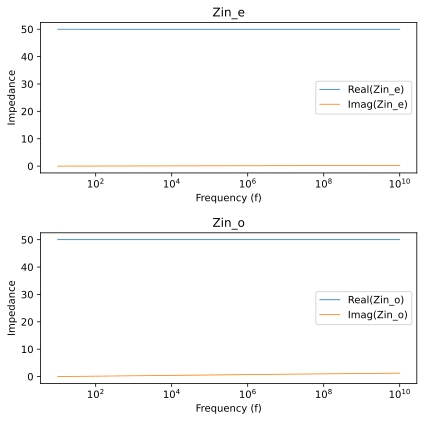

/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/1560888084.py:60: RuntimeWarning: overflow encountered in sin
  csc_theta_o = 1/np.sin(theta_o)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/1560888084.py:60: RuntimeWarning: invalid value encountered in divide
  csc_theta_o = 1/np.sin(theta_o)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/1560888084.py:61: RuntimeWarning: overflow encountered in sin
  csc_theta_e = 1/np.sin(theta_e)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/1560888084.py:61: RuntimeWarning: invalid value encountered in divide
  csc_theta_e = 1/np.sin(theta_e)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/1350987403.py:77: RuntimeWarning: overflow encountered in sin
  csc_theta_o = 1/np.sin(theta_o)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/1350987403.py:77: RuntimeWarning: invalid value encountered in divide
  csc_theta_o = 1/np.sin(theta_o)
/var/folders/v1/

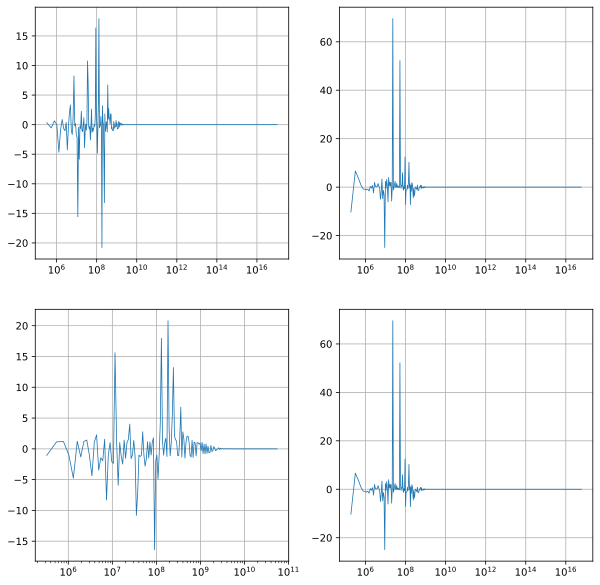

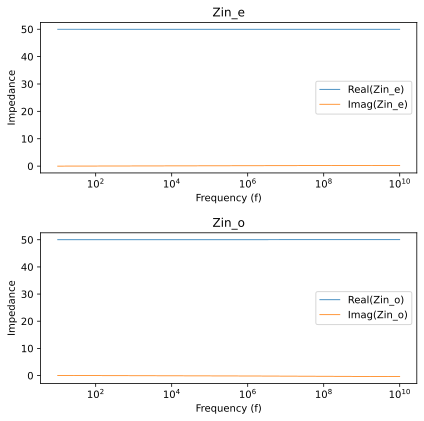

/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/1560888084.py:75: RuntimeWarning: overflow encountered in sin
  csc_theta_o = 1/np.sin(theta_o)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/1560888084.py:75: RuntimeWarning: invalid value encountered in divide
  csc_theta_o = 1/np.sin(theta_o)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/1560888084.py:76: RuntimeWarning: overflow encountered in sin
  csc_theta_e = 1/np.sin(theta_e)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/1560888084.py:76: RuntimeWarning: invalid value encountered in divide
  csc_theta_e = 1/np.sin(theta_e)


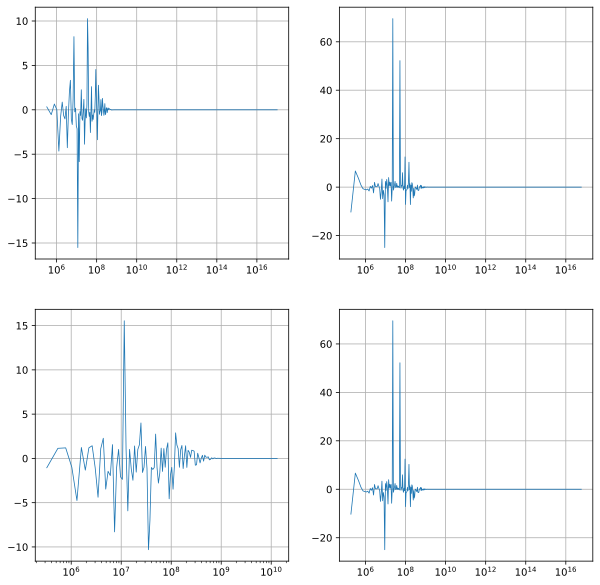

/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/133262773.py:8: RuntimeWarning: overflow encountered in sin
  csc_theta_o = 1/np.sin(theta_o)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/133262773.py:8: RuntimeWarning: invalid value encountered in divide
  csc_theta_o = 1/np.sin(theta_o)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/133262773.py:9: RuntimeWarning: overflow encountered in sin
  csc_theta_e = 1/np.sin(theta_e)
/var/folders/v1/t149q84d20s60ktyxvb3bft40000gn/T/ipykernel_4926/133262773.py:9: RuntimeWarning: invalid value encountered in divide
  csc_theta_e = 1/np.sin(theta_e)


In [19]:
if __name__ == "__main__":
    main()

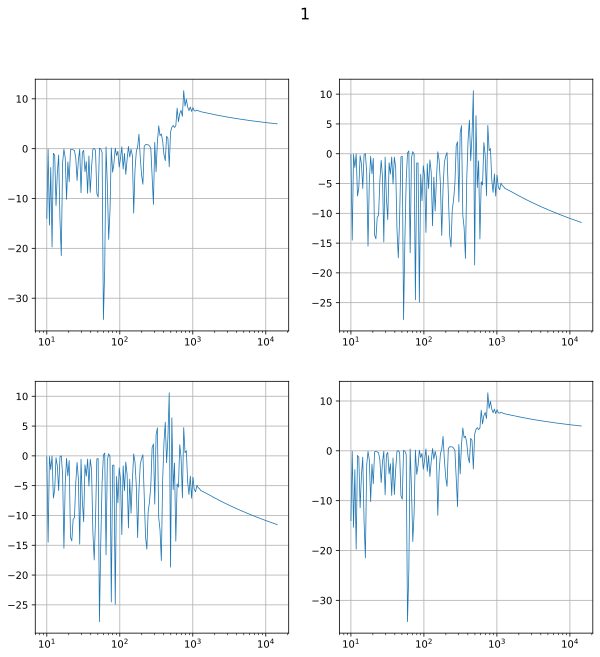

In [20]:
plot_S_params(f, S_storage1[0], "1")

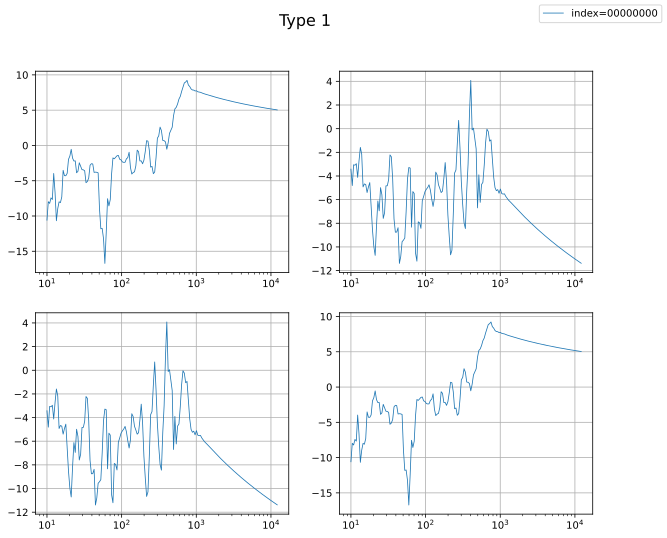

In [21]:
plot_all_possible_S_params(f, S_storage1, "Type 1", 1)

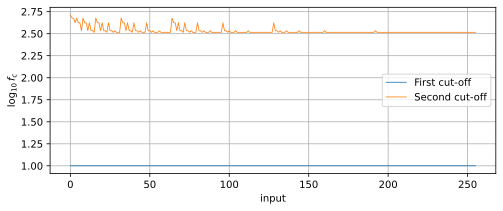

In [22]:
plot_cut_offs(f, S_storage1, 1)

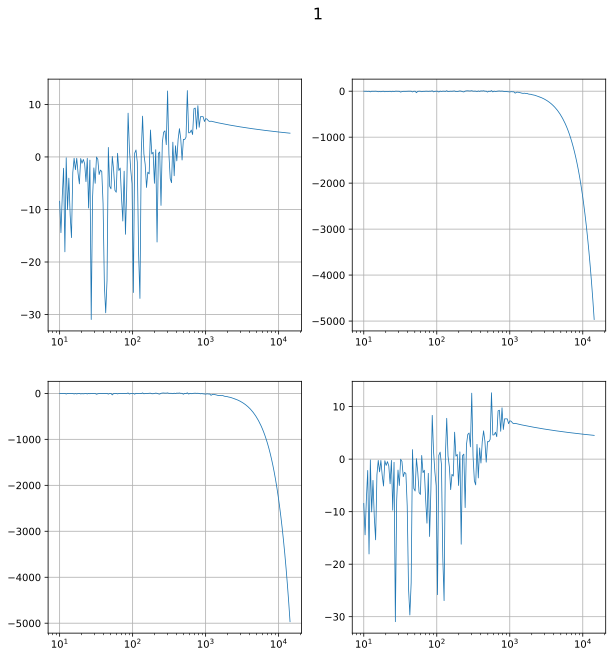

In [23]:
plot_S_params(f, S_storage4[0], "1")

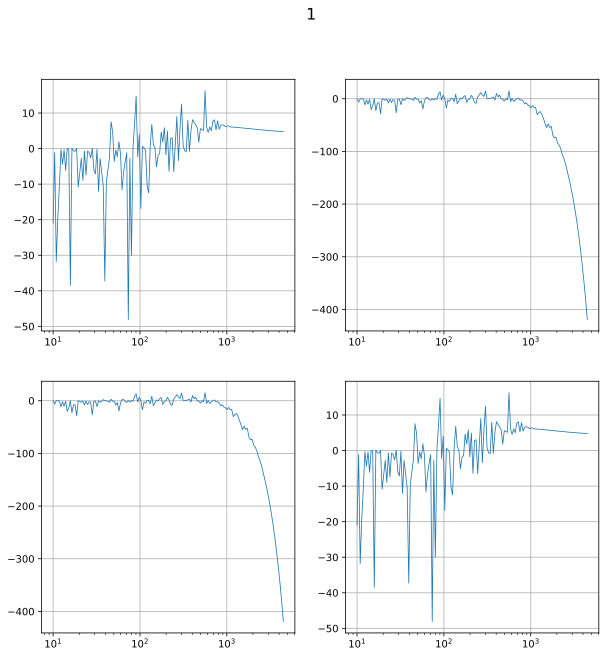

In [24]:
plot_S_params(f, S_storage4[140], "1")

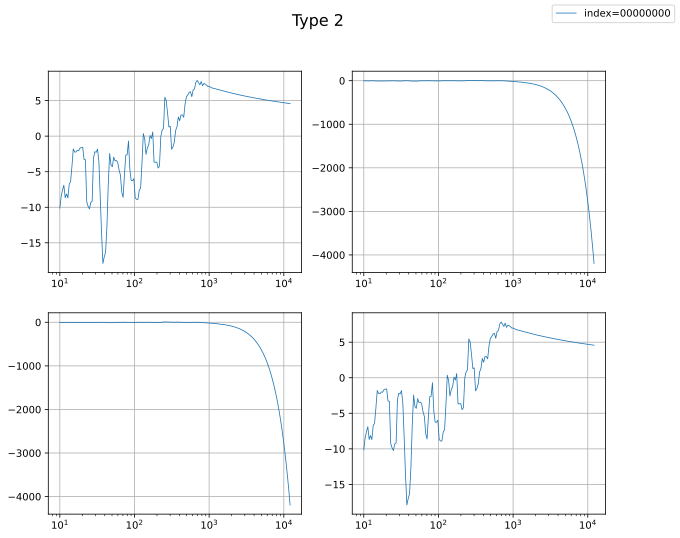

In [25]:
plot_all_possible_S_params(f, S_storage4, "Type 2", 1)

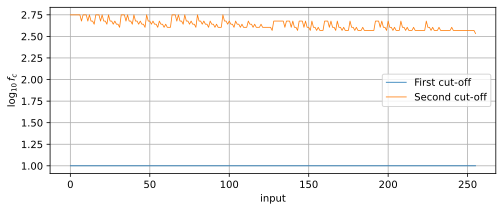

In [26]:
plot_cut_offs(f, S_storage4, 2)